In [1]:
import numpy as np
import argparse
import json
from pysam import VariantFile, TabixFile
import gzip
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import scipy.sparse as sparse

In [29]:
chrom = '22'
batch_num = 1
data_dir = '../../DATA/mssng/genotypes'
gnomad_vcf_file = '../data/gnomad.genomes.r3.0.sites.chr22.vcf.bgz'
ped_file = '../../DATA/mssng/mssng.ped'
n = 70000

In [30]:
with open('%s/info.json' % data_dir, 'r') as f:
	info = json.load(f)
	batch_size = info['batch_size']
	assembly = info['assembly']

with open('../data/chrom_lengths%s.json' % assembly, 'r') as f:
	chrom_length = json.load(f)[chrom]

In [31]:
# pull positions of interest
coord_file = '%s/chr.%s.%d.gen.coordinates.npy' % (data_dir, chrom, batch_num)
pos_data = np.load(coord_file)
if pos_data.shape[0]>0:
    positions = pos_data[:, 1]
    is_snp = pos_data[:, 2].astype(bool)
    is_pass = pos_data[:, 3].astype(bool)
    assert np.all(pos_data[is_snp][1:, 1]>pos_data[is_snp][:-1, 1])
else:
    positions = np.zeros((0,), dtype=int)
    
is_snp = pos_data[:, 2]==1
is_pass = pos_data[:, 3]==1
print(positions.shape)

(686138,)


In [32]:
refs, alts = [], []
with gzip.open('%s/chr.%s.%d.gen.variants.txt.gz' % (data_dir, chrom, batch_num), 'rt') as f:
    for line in f:
        pieces = line.strip().split('\t', maxsplit=5)
        refs.append(pieces[3])
        alts.append(pieces[4])
print(len(refs), len(alts))

686138 686138


In [33]:
def pull_af_from_info(info):
	af = -1
	for entry in info:
		if entry.startswith('AF='):
			af = float(entry[3:])
			break
	return af

def pull_af_from_gnomad(records, positions, refs, alts, is_snp, is_pass, n):
	position_ref_alt_to_index = dict([(x, i) for i, x in enumerate(zip(positions, refs, alts))])
	afs = np.zeros((len(positions),))
	was_backwards = 0
	for line in records:
		pieces = line.strip().split('\t')
		info = pieces[7].strip().split(';')
		pos, ref, alt = int(pieces[1]), pieces[3], pieces[4]
		if (pos, ref, alt) in position_ref_alt_to_index:
			afs[position_ref_alt_to_index[(pos, ref, alt)]] = pull_af_from_info(info)
		elif (pos, alt, ref) in position_ref_alt_to_index:
			afs[position_ref_alt_to_index[(pos, alt, ref)]] = 1-pull_af_from_info(info)
			was_backwards += 1

	print('% missing', np.sum(afs[is_snp & is_pass]==0)/np.sum(is_snp & is_pass))
	print('backwards', was_backwards)
	indices = is_snp & is_pass & (afs==0)
	for i in np.where(indices)[0]:
		print(positions[i], refs[i], alts[i])

	return np.clip(np.array(afs), 3/(2*n), 1-(3/(2*n))) # rule of 3

In [34]:
# load AF from appropriate section of gnomad vcf_file
if positions.shape[0]>0:
    vcf = TabixFile(gnomad_vcf_file, parser=None)
    if batch_size is not None:
        start_pos, end_pos = batch_num*batch_size, (batch_num+1)*batch_size
        print('Interval', start_pos, end_pos)
        gnomad_afs = pull_af_from_gnomad(vcf.fetch(reference='chr%s' % chrom, start=start_pos, end=end_pos),
                                        positions, refs, alts, is_snp, is_pass, n)
    else:
        gnomad_afs = pull_af_from_gnomad(vcf.fetch(reference='chr%s' % chrom),
                                        positions, refs, alts, is_snp, is_pass, n)


Interval 10000000 20000000
% missing 0.24657624788494079
backwards 1758
10521802 C T
10522926 A T
10527735 G C
10527756 C T
10528322 G C
10530218 A G
10530226 C G
10530347 T C
10530989 A C
10552218 C T
10561280 T C
10561493 G A
10565161 A T
10570007 C G
10572892 C G
10573125 G C
10581755 G T
10586794 A C
10588034 G A
10588305 G A
10588355 T C
10588696 A C
10591183 C T
10591221 A C
10591243 A C
10591447 C A
10591780 T C
10592730 G A
10592743 C A
10592858 C G
10595061 G A
10595164 G A
10595538 T C
10598547 T A
10598616 T A
10603751 T C
10606491 T A
10606717 A G
10606994 G A
10610915 G A
10610916 T A
10611546 G A
10611575 T C
10612615 T A
10612740 T A
10613106 C T
10613683 A G
10615875 A G
10616245 A C
10616255 G A
10616260 A C
10616367 A G
10618227 T C
10620231 A G
10624723 G C
10625172 T C
10625775 C T
10625841 A C
10625844 A C
10631832 C G
10631863 C A
10632164 G A
10632976 C T
10633193 T C
10633202 C T
10633328 C T
10634664 G A
10636584 C T
10638541 A G
10638712 T C
10639044 C T
10639

10730427 G T
10730429 A C
10730431 C G
10730437 C T
10730446 T A
10730461 C G
10730476 A G
10730493 A G
10730494 T A
10730499 C G
10730501 T C
10730504 G A
10730505 G A
10730508 G A
10730511 T A
10730519 A T
10730558 A G
10730560 A G
10730576 T C
10730581 C T
10730584 A C
10730587 G T
10730610 A G
10730632 A T
10730636 T A
10730644 A T
10730678 G T
10730712 G T
10730723 A G
10730724 T C
10730732 T A
10730782 C T
10730792 G A
10730793 C T
10730801 A C
10730805 T C
10730813 C T
10730815 A C
10730829 C A
10730839 C T
10730897 T A
10730904 T A
10730941 T G
10730970 C T
10730975 G T
10731015 C T
10731086 C A
10731136 G A
10731140 T A
10731330 C T
10731334 G A
10731342 G A
10731345 C T
10731367 C T
10731371 C A
10731375 C A
10731380 C A
10731389 T G
10731398 T G
10731401 T A
10731407 C A
10731410 G T
10731417 C T
10731429 C A
10731442 G A
10731445 G T
10731451 G A
10731459 A T
10731477 G A
10731479 G A
10731492 G T
10731523 G A
10731545 G A
10731551 C T
10731584 A T
10731594 T A
10731601 T A

10778789 C T
10778857 C T
10779004 T C
10779565 A T
10779571 T G
10779599 T C
10779603 T C
10779611 A G
10779624 A G
10779677 G A
10779679 C T
10779685 T G
10779708 C G
10779716 C A
10779720 C G
10779723 C T
10779725 A T
10779740 C G
10779742 T A
10779750 G A
10779752 C G
10779757 G A
10779764 A C
10779767 C G
10779778 A T
10779801 C T
10779805 A G
10779810 A T
10779811 C T
10779830 C T
10779839 T C
10779841 G A
10779859 C T
10779866 C T
10779873 G C
10779875 A G
10779879 C G
10779885 A G
10779915 G A
10779923 G A
10780138 C T
10780147 C T
10780148 T C
10780149 C T
10780169 C G
10780211 C A
10780237 A T
10780257 A G
10780305 G T
10780310 G A
10780320 C T
10780324 G A
10780328 C T
10780336 C T
10780337 C T
10780340 A T
10780351 G T
10780352 A T
10780359 G T
10780360 G A
10780369 C A
10780395 A C
10780402 A T
10780407 T A
10780425 C A
10780430 T G
10780473 A G
10780490 C T
10780519 C T
10780548 G A
10780555 C T
10780561 G T
10780578 T C
10780593 C A
10780599 A G
10780614 G T
10780618 T C

10938041 G A
10938092 C T
10938150 T A
10938178 C T
10938180 T C
10938194 G A
10938260 T A
10938281 C A
10938289 T G
10938336 C T
10938555 A C
10938571 A C
10938574 C A
10938605 G A
10938973 T C
10939018 A T
10939326 C G
10939340 A G
10939376 C T
10939382 T C
10939393 T C
10940270 A G
10940418 T C
10940434 T A
10940454 G A
10940546 C T
10940643 T A
10940644 A G
10940661 C G
10940703 T G
10940776 T A
10940805 T C
10941000 G T
10941041 G T
10941108 G A
10941109 G C
10941121 G C
10941185 C G
10941190 G C
10941209 G A
10941231 T C
10941240 A G
10941255 C T
10941257 C T
10941300 A G
10941308 A G
10941328 C T
10941330 A T
10941399 C T
10941479 C T
10941490 G T
10941499 C A
10941530 A G
10941643 C T
10941783 A G
10941841 A G
10941899 T A
10941962 T C
10942355 T C
10942372 T G
10942405 C A
10942452 C T
10942477 G T
10942525 C T
10942560 T C
10942585 G T
10942624 T A
10942631 A C
10942692 A C
10942714 A C
10942898 T A
10942914 A G
10942915 T C
10943146 A G
10943157 T A
10943459 C T
10943748 T A

11059575 C T
11059576 C T
11059581 T C
11059589 T G
11059595 T C
11059606 G A
11059607 T C
11059608 A G
11059616 A C
11059643 T A
11059681 C T
11059717 T G
11059720 C G
11059732 A T
11059751 G A
11059763 T C
11060195 G A
11060222 T C
11060236 T C
11060245 G C
11060255 A T
11060285 A G
11060287 T C
11060292 A C
11060296 G T
11060313 T A
11060340 G A
11060342 C T
11060349 A G
11060361 A T
11060684 T A
11060687 C G
11060690 C T
11060693 A G
11060698 T C
11060701 G T
11060715 A G
11060719 A G
11060725 G T
11060737 G A
11060739 A C
11060742 A G
11060766 C T
11060787 T C
11060818 C T
11060821 G T
11060838 C T
11060884 G T
11060886 C T
11060973 T A
11060974 G T
11060986 G T
11061005 C A
11061019 G T
11061027 C T
11061032 A G
11061035 G A
11061047 C G
11061051 C T
11061054 G A
11061063 C A
11061069 G T
11061091 T A
11061097 A G
11061128 A G
11061137 C A
11061143 A T
11061153 G T
11061167 C A
11061171 C T
11061183 G T
11061224 A C
11061244 A C
11061254 A G
11061259 A C
11061273 T A
11061277 G A

11309519 G A
11309535 A G
11309538 A G
11309548 A C
11309563 T C
11309569 C A
11309628 G A
11309771 G T
11309807 C T
11309840 C G
11309852 G T
11309879 T C
11309943 G A
11309954 C G
11309969 T G
11309976 C T
11310039 T G
11310072 T G
11310089 C T
11310165 A G
11310319 G A
11310325 T A
11310345 T G
11310433 C A
11310504 A T
11310573 G A
11310704 C T
11310724 C G
11310735 C T
11310748 A C
11310827 G A
11310881 G T
11310954 C A
11311136 C T
11311153 T A
11311478 G A
11311723 G T
11311782 G C
11311788 G T
11311794 C G
11311797 A G
11311806 G T
11311808 A C
11311854 T C
11311903 T C
11311951 T C
11312043 T C
11312053 G A
11312075 C T
11312086 T G
11312103 G A
11312116 G C
11312171 T C
11312418 T C
11312454 A C
11312556 T C
11312598 C A
11312612 A G
11312617 C G
11312642 A T
11312692 G T
11312743 G T
11312744 G T
11312820 G A
11312898 G A
11312933 G A
11312954 G T
11313031 G T
11313349 C T
11313369 C T
11313414 C T
11313438 C G
11313486 T C
11313492 G A
11313531 C A
11313534 C T
11313558 C T

11365785 A G
11365837 A G
11365849 C A
11365884 C G
11365913 A T
11365921 G T
11365946 C A
11365969 G A
11366023 T A
11366042 T G
11366044 C T
11366054 C G
11366057 C G
11366078 T G
11366112 G T
11366128 T G
11366156 G A
11366159 T C
11366203 A C
11366279 A C
11366282 T G
11366288 T C
11366312 A G
11366372 G A
11366403 G A
11366430 G T
11366433 G A
11366435 G A
11366473 C A
11366476 G A
11366522 C G
11366569 C T
11366611 A C
11366656 T C
11366675 C G
11366724 C T
11366735 G T
11366737 T A
11366809 T G
11366813 G T
11366858 G A
11366869 C A
11366942 G C
11366954 C A
11366970 T A
11367007 A G
11367023 T C
11367050 G A
11367087 G A
11367203 C A
11367212 C G
11367331 A T
11367430 A T
11367472 A G
11367491 T C
11367590 C T
11367616 T C
11367632 T G
11367660 G T
11367707 A T
11367715 C G
11367747 C A
11367850 T A
11367874 G A
11368000 A C
11368002 G A
11368065 G C
11368094 G A
11368095 A T
11368104 A C
11368110 A G
11368118 T A
11368122 A G
11368123 A C
11368229 C A
11368233 T A
11368304 T C

11583422 A G
11583425 T C
11583448 C G
11583544 G A
11583630 A G
11583647 G T
11583653 T C
11583695 T C
11583715 A C
11583757 G T
11583902 A G
11583953 T C
11584024 T A
11584067 C T
11584081 T C
11584100 A G
11584110 A G
11584171 T A
11584239 T C
11584258 C G
11584274 C T
11584293 A T
11584334 T C
11584573 C A
11584996 C A
11584999 T C
11585048 A C
11585071 C G
11585102 C G
11585106 A T
11585134 A G
11585251 T C
11585252 A G
11585305 A G
11585341 C G
11585486 G A
11585553 C G
11586144 T C
11586176 A C
11586217 T G
11586226 G A
11586270 T G
11586277 T C
11586350 G C
11586411 G A
11586432 A T
11586474 A T
11586482 G A
11586490 T C
11586526 T G
11586551 T C
11586560 C A
11586584 C T
11586592 T C
11586626 A T
11586657 C T
11586685 C A
11586776 G C
11586792 G A
11586806 C A
11587272 A C
11587322 C A
11587323 C G
11587325 G A
11587380 C A
11587388 T C
11587426 A C
11587435 C T
11587578 G C
11587593 C T
11587598 C A
11587601 T C
11587618 C G
11587691 A G
11587725 A G
11587955 C T
11587996 A T

11625755 C A
11625758 A C
11625761 C A
11625771 A G
11625788 C G
11625853 C T
11625860 G C
11625874 G A
11625879 G C
11625887 C T
11625960 C A
11625967 G A
11626036 A T
11626074 T C
11626120 A C
11626165 A G
11626224 T C
11626271 T C
11626355 A G
11626361 T G
11626387 G A
11626408 C G
11626414 T A
11626424 G A
11626455 C G
11626494 G A
11626555 C G
11626574 C G
11626657 C A
11626715 G T
11626750 C T
11626784 C T
11626844 G A
11626854 C A
11626863 T C
11626882 A T
11626904 A G
11626927 T A
11626934 A G
11627019 A T
11627030 C A
11627063 T A
11627072 G A
11627085 G C
11627228 G T
11627237 T C
11627252 G T
11627298 A T
11627313 A T
11627330 C A
11627346 A C
11627382 A T
11627480 G T
11627500 G C
11627555 T C
11627560 G A
11627573 A G
11627581 C A
11627681 G A
11627722 C A
11627727 T C
11627743 G T
11627945 G A
11627972 C T
11627994 T C
11627998 C T
11628003 G T
11628021 A G
11628022 A T
11628048 G T
11628104 T C
11628153 G A
11628157 G A
11628281 T G
11628342 T G
11628370 G T
11628373 G A

12039099 T C
12039148 G C
12039205 T A
12039225 C T
12039227 T G
12039242 T A
12039257 C T
12039318 A T
12039341 T C
12039364 C T
12039652 A G
12039860 A G
12039949 G A
12040354 G A
12040482 T A
12040507 T C
12041020 C A
12041023 C A
12041034 A C
12041050 A G
12041055 G A
12041101 C A
12041116 A C
12041143 C T
12041193 C G
12041729 C T
12041732 G A
12041736 C T
12041761 C T
12041775 C G
12042141 A T
12042156 G T
12042187 G T
12042191 G T
12042196 T G
12042216 T G
12042243 T A
12042324 T G
12042415 G C
12042455 A G
12042491 T C
12042503 A T
12042546 C G
12042562 C A
12043176 T C
12043220 C A
12043231 A G
12043269 G A
12043290 A G
12043628 A G
12043649 C G
12043680 T A
12043682 G T
12043709 C T
12043721 C A
12043749 T C
12043762 T G
12043789 A C
12043829 G A
12044088 A G
12044469 A T
12044497 C A
12044511 C A
12044514 G C
12044539 A C
12044612 C T
12044629 C T
12044684 A G
12044697 C G
12044829 A C
12044830 T A
12044831 G T
12044964 A G
12045144 A T
12045181 A G
12045185 A G
12045215 A G

12384815 T G
12384849 G A
12384862 T A
12384877 T C
12384890 A G
12384919 T A
12384923 A G
12384942 G A
12384976 G C
12385025 G A
12385480 T G
12385496 T A
12385519 T C
12385539 G T
12385589 A C
12385609 T C
12385610 T A
12385623 T C
12385652 T G
12385797 A G
12385802 A C
12385828 A T
12385857 A G
12385883 G A
12385891 G A
12385902 A G
12385951 T C
12386032 T A
12386535 T C
12386973 A T
12386983 T G
12387221 G A
12387421 T C
12388032 T A
12388037 C T
12388049 T A
12388069 T A
12388127 A G
12388153 C A
12388172 G A
12388301 T A
12388341 G A
12388352 G A
12388396 T A
12388403 T C
12388424 A T
12388538 A G
12388550 C A
12388573 C T
12388602 A G
12388651 A G
12388673 A G
12388772 T C
12388774 T A
12388813 T G
12388848 A C
12388866 T C
12388895 G A
12388921 T A
12388955 G C
12388989 C T
12389081 C G
12389141 A G
12389145 T C
12389159 G A
12389212 C G
12389213 T G
12389226 T C
12389248 A C
12389280 G A
12389284 G A
12389356 C T
12389372 T A
12389381 T G
12389412 G T
12389433 G A
12389488 G T

12416200 T C
12416418 T A
12416473 A C
12416475 C T
12416482 T A
12416501 C A
12416522 C T
12416523 T G
12416546 T C
12416577 A G
12416609 G A
12416684 G A
12416695 G A
12416764 T C
12416782 G A
12416827 T C
12416829 C T
12416920 A C
12416956 G T
12416959 C A
12416975 C T
12417021 T C
12417067 C T
12417079 T A
12417515 C A
12417912 T G
12417950 C A
12417955 T G
12418046 A G
12418194 A C
12418197 T C
12418213 A G
12418217 G T
12418407 A G
12418490 T A
12418502 T A
12418545 C A
12418569 C A
12418627 T C
12418654 G A
12418665 A C
12418696 T C
12418736 A G
12418759 A G
12418814 T G
12419220 C T
12419271 G A
12419291 T C
12419803 T C
12419806 G T
12419846 T C
12419886 A C
12419907 A T
12419911 A C
12419973 C A
12420108 A G
12420584 G T
12420654 A T
12420819 A T
12420913 G A
12420964 C G
12420973 T C
12421019 T G
12421099 C T
12421100 C T
12421117 G A
12422029 G A
12422042 T C
12422057 A T
12422107 G T
12422662 T C
12422698 A G
12422715 G T
12422723 A C
12422854 A G
12422917 T C
12422936 A G

12609769 A T
12609771 A G
12609783 A T
12609787 G A
12609907 T G
12609922 A T
12610023 T A
12610024 C A
12610058 G A
12610060 T C
12610095 G C
12610121 C A
12610123 G C
12610189 A C
12610192 T C
12610198 T G
12610201 T C
12610245 G T
12610259 G A
12610270 G A
12610358 A G
12610378 T G
12610382 T G
12610400 C G
12610408 G T
12610481 C A
12610609 A G
12610610 T G
12610668 C A
12610697 C G
12610738 G T
12610763 A G
12610806 G T
12610822 G C
12610843 G T
12611005 A C
12611017 G A
12611145 A C
12611396 C G
12611398 G C
12611413 C G
12611447 C G
12611513 G A
12611516 G T
12611517 T C
12611791 G T
12611822 C T
12611871 T A
12611956 G T
12612014 A C
12612015 C A
12612023 G T
12612059 T C
12612081 C G
12612110 T A
12612190 C T
12612217 T C
12612323 A T
12612331 C T
12612336 A G
12612346 T G
12612423 C A
12612534 G T
12612539 T C
12612672 A T
12612736 A T
12612982 C A
12613148 A G
12613208 G A
12613283 C T
12613286 T C
12613291 G A
12613333 G T
12613355 G A
12613405 A T
12613415 G T
12613437 G A

12787058 A T
12787294 A G
12787309 G C
12787364 G T
12787393 G A
12787434 C G
12787436 C A
12787464 C T
12787577 C A
12787593 A C
12788072 C A
12788092 G T
12788139 A T
12788964 T G
12789044 C G
12789047 G A
12789086 C T
12789125 G T
12789359 T A
12789518 C T
12789622 T C
12789726 G A
12789995 G T
12790007 G T
12790047 A C
12790048 A G
12790073 T C
12790526 C T
12790543 C T
12790556 A G
12791095 T C
12791334 C A
12791521 T G
12792618 T A
12792627 C A
12793303 T C
12793316 C T
12793694 G A
12793729 C T
12793739 C T
12793768 T G
12793779 T A
12793792 G C
12794108 G C
12795836 C G
12795878 T C
12796093 C A
12796097 A T
12796115 T C
12796117 G A
12796278 G A
12796989 G C
12797121 G A
12797128 T A
12797171 G A
12797190 C A
12797702 A T
12797895 T A
12798058 A C
12798087 G A
12798157 T A
12798294 C G
12798327 A T
12798328 T A
12798438 T G
12798802 G A
12798806 G C
12798825 A G
12798828 T A
12799149 C A
12799251 T C
12799258 A C
12799281 C A
12799311 G C
12799317 C G
12799713 T A
12799721 C T

15636457 A G
15636498 G T
15636516 G T
15636527 G A
15636574 T A
15636796 T G
15636991 G A
15636994 G A
15637012 C T
15637053 C T
15637062 T G
15637115 C A
15637405 T C
15637552 C T
15637673 G C
15638044 C T
15642064 C G
15642480 G A
15642493 C T
15649993 G A
15652831 T G
15653437 G C
15657638 C G
15660829 A G
15663872 T C
15664818 T G
15665494 G A
15665496 A G
15665553 C T
15665583 A T
15665600 T C
15665611 G A
15665750 G C
15665768 C G
15666924 G C
15667543 T C
15667546 C G
15672011 A G
15672066 A G
15672489 T C
15672605 T C
15672764 T C
15672911 C A
15673126 A T
15675537 G A
15677605 T C
15680267 A G
15685904 A T
15687329 C G
15687569 A G
15688364 G C
15688401 G T
15688530 G T
15689170 A C
15689827 C A
15690731 G T
15690776 G T
15690780 G C
15690822 C G
15690846 G A
15690852 G C
15690960 A C
15690968 A G
15690987 T C
15691819 A T
15691934 A T
15692056 A G
15692742 G T
15692801 A G
15699892 T C
15703643 T A
15705468 T C
15709043 G A
15709051 A G
15710235 A T
15712576 A G
15712847 C A

16036499 G T
16036521 G A
16036531 C A
16036666 A G
16036718 A C
16036720 T G
16036831 T C
16036844 T A
16037038 C A
16037043 C A
16037060 A G
16037067 T C
16037068 G A
16037075 G T
16037081 G A
16037173 G T
16037174 A G
16037190 T A
16037282 T A
16037293 C A
16037302 G T
16037321 A T
16037435 C A
16037440 T A
16037451 C T
16037506 C G
16037510 T C
16037514 T A
16037632 C T
16037637 A C
16037696 C G
16037731 G T
16037739 T G
16037756 A G
16037764 C T
16037835 G A
16037852 T C
16037963 G A
16038050 C A
16038058 C T
16038156 A C
16038216 T C
16038253 C A
16038258 A G
16038280 G T
16038284 T C
16038300 T G
16038302 T C
16038334 T A
16038337 A G
16038338 A G
16038341 A G
16038342 T C
16038355 C T
16038381 A G
16038432 T C
16038461 A G
16038473 T G
16038538 T A
16038557 G A
16038585 T C
16038588 T C
16038617 A G
16038728 G A
16038809 A C
16038826 T A
16038831 A T
16038844 A T
16038845 C A
16038922 A C
16038928 G T
16038943 G A
16038959 T A
16038985 G T
16038998 A T
16039026 T C
16039032 A G

16087935 A C
16088045 A C
16088303 G T
16088530 T G
16088582 A G
16088769 A G
16088790 C T
16088828 A T
16088831 T C
16088877 G T
16088903 T G
16088919 G A
16088921 C T
16088952 C T
16089126 A T
16089143 C A
16089171 A G
16089172 A G
16089181 A G
16089265 G A
16089297 T G
16089411 G C
16089466 A G
16089486 T C
16089546 C T
16089649 C A
16089789 A C
16089896 C A
16089943 G A
16090237 A G
16090241 T A
16090257 C A
16090389 A T
16090439 A T
16090551 T A
16090586 G T
16090611 T C
16090644 C T
16090645 T C
16090649 C G
16090808 C T
16090911 A T
16091035 T A
16091093 T C
16091113 C G
16091116 T C
16091151 A G
16091203 G T
16091216 C T
16091225 G T
16091306 T A
16091326 C G
16091331 A G
16091338 A C
16091361 G A
16091391 T A
16091446 C A
16091496 C T
16091560 T A
16091571 A T
16091639 T C
16091652 A G
16091816 T C
16091833 T C
16091843 T C
16091859 A G
16091889 T A
16091904 G C
16091974 A C
16092069 C T
16092077 C A
16092091 T A
16092092 C G
16092127 C T
16092155 A C
16092156 G C
16092180 T C

16148281 G C
16148328 C T
16148341 C T
16148380 C T
16148413 G A
16148421 C T
16148428 C G
16148499 G C
16148556 T G
16148572 G C
16148602 G A
16148664 G C
16148701 T G
16148716 A T
16148847 C G
16149007 A G
16149024 G T
16149057 G A
16149287 C A
16149299 A T
16149300 C T
16149369 C A
16149381 G A
16149415 G A
16149468 C G
16149606 C A
16149639 T A
16149658 A G
16149677 G A
16149681 G A
16149682 T C
16149776 C G
16149921 C T
16149950 G T
16149988 T A
16150023 C A
16150031 C A
16150251 G T
16150252 A T
16150362 A G
16150384 A G
16150478 G A
16150543 T C
16150581 T C
16150618 T C
16150690 C T
16150702 C A
16150703 C A
16150729 G T
16150885 C A
16150957 A T
16151002 A T
16151062 T A
16151130 T A
16151179 A T
16151182 G A
16151207 C A
16151274 C T
16151443 C T
16151481 A G
16151565 T G
16151578 G A
16151591 A C
16151600 A G
16151609 A T
16151654 A C
16151698 T C
16151738 A G
16151804 G T
16151930 G A
16151931 G A
16151963 G A
16152008 A G
16152059 G A
16152066 A G
16152098 C A
16152156 T G

16203837 A C
16203871 A C
16203943 T C
16203950 C G
16203966 G C
16204081 A G
16204118 C T
16204128 G C
16204143 C A
16204159 A G
16204210 T A
16204225 T G
16204228 C T
16204335 A G
16204395 G A
16204434 T C
16204498 C T
16204517 A G
16204594 A C
16204611 G T
16204669 G A
16204683 G C
16204875 C A
16204886 C A
16204896 G C
16205040 G A
16205286 G A
16205379 A G
16205405 A T
16205428 C G
16205560 C A
16205582 T C
16205616 C T
16205633 A T
16205780 G C
16205801 C A
16205828 T A
16205874 G A
16205921 C G
16205938 A G
16206075 A T
16206096 A G
16206121 C T
16206130 C A
16206167 G A
16206173 G A
16206197 C A
16206224 G A
16206238 C T
16206331 T G
16206335 C A
16206447 C T
16206487 A G
16206566 A G
16206575 T C
16206602 A G
16206619 T C
16206727 G T
16206865 G A
16206956 T A
16206963 G A
16206966 T A
16207042 T A
16207091 T C
16207132 C G
16207139 C T
16207418 T A
16207463 G T
16207524 G T
16207678 C G
16207700 T A
16207845 A T
16207869 A T
16207909 T A
16207934 A G
16207939 C A
16207971 A G

16254760 A G
16254778 G A
16254800 T A
16254817 G T
16254834 A G
16254843 A G
16254859 G A
16254873 A G
16255133 A T
16255209 A G
16255264 T C
16255443 G T
16255464 G A
16255466 T C
16255476 A T
16255619 T A
16255638 T C
16255659 A T
16255694 G A
16255917 T A
16256388 C G
16256664 A G
16256666 T C
16256701 A G
16256848 C T
16256856 T C
16256881 A G
16256917 C T
16256978 T G
16257073 T A
16257117 A G
16257331 C G
16257414 G A
16257523 G A
16257619 T C
16257649 C T
16257980 T C
16258435 A C
16258543 G T
16258700 A G
16258730 G A
16258839 G T
16258938 G A
16259088 A G
16259116 T G
16259264 C T
16259270 G T
16259317 T G
16259389 T G
16259408 T C
16259454 C T
16259605 G T
16259622 A T
16259701 C G
16259776 C T
16259917 T C
16259920 G A
16259946 C T
16260000 G T
16260029 G T
16260275 C G
16260285 C T
16260327 C A
16260360 T C
16260400 T G
16260451 C T
16260495 G T
16260511 A G
16260520 T G
16260532 C G
16260572 C G
16260733 A T
16260774 C T
16260786 T C
16260960 C T
16261005 A T
16261010 A T

16396419 C G
16396526 G A
16396573 T C
16396676 C T
16396713 T A
16396813 A G
16396814 T C
16396839 G A
16396985 G C
16396990 T G
16397125 C T
16397211 C A
16397228 C T
16397303 C A
16397365 T G
16397519 T C
16397522 T C
16397638 T A
16398128 G T
16398247 G T
16398281 A G
16398304 G T
16398312 C A
16398316 C T
16398459 G A
16398490 G A
16398499 C T
16398515 C A
16398555 T C
16398575 G A
16398621 A C
16398670 A G
16398718 C A
16398737 C T
16398814 T A
16398830 A G
16398867 T A
16398868 T A
16398872 T A
16398902 C A
16398954 T C
16399373 G A
16399485 G T
16399559 C T
16399570 T G
16399712 T A
16399748 T G
16399807 A T
16400046 A C
16400236 C T
16400324 C A
16400336 C T
16400471 C T
16400475 T C
16400546 C A
16400712 A G
16400793 A G
16401046 C A
16401148 C G
16401269 C T
16401300 A G
16401341 C A
16401519 A G
16401591 G A
16401669 C T
16401896 G T
16402789 T C
16402842 A G
16402898 A G
16403415 G A
16403429 G A
16403448 G A
16403485 G T
16403534 C T
16403538 C T
16403540 A G
16403653 A T

16539560 T C
16539571 A G
16539659 C T
16540114 T C
16540208 A T
16540212 G T
16540216 C G
16540403 T C
16540412 T C
16540415 G T
16540541 C A
16540564 G A
16540606 A T
16541075 G T
16541091 G A
16541119 A T
16541136 A C
16541164 A T
16541223 G A
16541241 T C
16541330 A G
16541342 T A
16541379 A G
16541395 T C
16541398 T C
16541415 G A
16541422 A G
16541430 A G
16541653 A G
16541788 G A
16541802 A C
16541864 G A
16542048 G A
16542094 C A
16542120 T C
16542152 G A
16542159 T A
16542187 C G
16542293 A G
16542357 A T
16542374 T A
16542385 T G
16542420 C T
16542478 A G
16542489 A G
16542490 T G
16542497 A G
16542499 G A
16542503 C T
16542539 A G
16542586 T C
16543168 G T
16543330 T C
16543374 C T
16543438 C T
16543565 C T
16543755 C A
16543793 G T
16543847 C A
16544060 T A
16544062 T A
16544077 G A
16544104 C A
16544329 T A
16544375 G A
16544520 T C
16544566 C T
16544571 C A
16544625 T C
16544725 C G
16544755 C A
16544815 G A
16544836 A G
16544887 G A
16544888 A C
16544892 T C
16544955 C G

16646788 T C
16646840 A G
16646849 T C
16646857 G T
16646871 G T
16647182 G A
16647193 C G
16647195 T C
16647202 C T
16647215 T A
16647228 T C
16647283 G A
16647430 A T
16647437 A G
16647555 T A
16647713 T C
16647804 G C
16647828 C T
16647830 G A
16647841 C T
16647977 G T
16648004 G T
16648053 G T
16648427 C A
16648490 T G
16648556 A T
16648571 T C
16648590 C T
16648753 G C
16648758 A G
16648790 G A
16648794 C A
16648898 G A
16648935 C G
16649075 A T
16649097 T C
16649123 A G
16649269 A G
16649330 G A
16649331 T G
16649339 C T
16649405 C T
16649428 C T
16649595 T G
16649620 G A
16649641 C T
16649655 G A
16649668 G A
16649769 G C
16649838 A G
16649961 G A
16649965 A G
16650371 G T
16650485 G A
16650686 G A
16650789 G A
16650803 G C
16650862 C G
16650944 A T
16650998 G T
16651049 C G
16651103 G T
16651123 G A
16651138 G C
16651274 A C
16651296 G A
16651299 A T
16651371 C T
16651377 G A
16651425 C G
16651431 G A
16651489 C T
16651496 A T
16651506 A G
16651564 A G
16651672 A G
16651749 T C

16750038 C T
16750092 G A
16750338 A C
16750339 C T
16750621 G T
16750752 T G
16750824 C A
16750909 A G
16751016 T A
16751296 A G
16751434 A G
16751517 A T
16751547 A G
16751548 G A
16751815 T A
16751862 C T
16751971 G A
16752050 C A
16752056 C T
16752058 A G
16752153 G A
16752211 C A
16752330 T C
16752582 T C
16752757 G A
16752759 G A
16752858 G T
16752920 G A
16752930 C A
16753427 G C
16753484 A G
16753551 T C
16753590 G A
16753609 C G
16753655 T C
16753691 A T
16753814 C T
16753835 T C
16753864 G A
16753877 A T
16753940 G A
16754005 C T
16754159 A G
16754274 C A
16754341 T C
16754356 T C
16754504 T C
16754553 G T
16754684 G A
16754880 C T
16754884 T A
16754899 C G
16754999 A T
16755033 A T
16755059 G A
16755223 T A
16755234 G C
16755278 T C
16755307 C A
16755339 T G
16755430 A G
16755495 A G
16755559 T C
16755624 A T
16755683 C T
16755700 G A
16755803 A G
16755810 C T
16755859 T C
16755880 T A
16756015 C A
16756090 C T
16756117 G A
16756201 G A
16756211 G A
16756355 C T
16756358 C G

16817938 C T
16817960 G A
16817977 T C
16817992 G A
16818021 A G
16818086 G A
16818106 G C
16818160 C T
16818417 C T
16818429 T C
16818587 A G
16818596 A G
16818627 A T
16818823 C T
16818834 T C
16818962 A G
16819018 A G
16819271 A T
16819383 T C
16819388 G C
16819482 C A
16819555 A G
16819658 G A
16819727 C A
16819902 C T
16820017 A C
16820044 G T
16820093 A G
16820095 A T
16820110 C A
16820125 A G
16820335 T C
16820567 T C
16820609 C A
16820838 A G
16820852 A T
16820892 T C
16820911 T C
16821237 A G
16821408 T C
16821496 T C
16821516 C G
16821536 C T
16821537 A T
16821544 G T
16821641 G C
16821675 G A
16821743 T C
16821880 C T
16822030 T C
16822111 T C
16822207 A G
16822226 T A
16822451 A T
16822481 A G
16822513 G C
16822538 A T
16822575 C T
16822651 T G
16822654 T C
16822659 T C
16822767 T A
16822889 T C
16823301 A C
16823315 T G
16823401 A C
16823474 G C
16823504 G T
16823532 T C
16823710 C A
16823728 C T
16823767 T A
16823782 T G
16823824 A T
16823947 G A
16824103 G A
16824193 G C

16930970 G A
16930971 G A
16931022 A T
16931088 T C
16931275 G C
16931435 T C
16931454 A G
16931465 G A
16931601 G A
16931713 G A
16931737 G A
16931760 A G
16932011 G C
16932122 C T
16932209 C T
16932273 C A
16932302 G C
16932333 A T
16932380 G T
16932504 A T
16932523 G A
16932629 A G
16932735 G A
16932756 G C
16932791 T C
16932822 A G
16932977 G C
16932993 G C
16933061 C T
16933064 T C
16933078 G A
16933114 T C
16933122 T C
16933191 T C
16933333 A G
16933382 T C
16933458 G T
16933666 G A
16933669 T C
16933846 A G
16933950 T C
16934092 T C
16934246 T A
16934289 C T
16934303 A C
16934405 T C
16934588 A T
16934849 C T
16934962 G T
16935047 A C
16935234 A G
16935262 T C
16935363 T C
16935366 A G
16935386 G A
16935493 G C
16935721 T A
16935761 C T
16935836 G A
16935854 C A
16935905 G A
16935926 C A
16935934 G A
16935935 G A
16936066 A G
16936143 G A
16936216 C T
16936255 T G
16936314 A G
16936367 T A
16936583 A T
16936679 C T
16936745 A C
16936797 G A
16936850 C T
16936999 A G
16937033 C T

17002895 G C
17002918 T C
17002961 G A
17003191 T C
17003262 G A
17003281 A G
17003454 T C
17003485 A G
17003499 T C
17003728 G A
17003863 T C
17003941 G T
17004170 A C
17004199 C T
17004344 C T
17004429 A G
17004510 G C
17004669 A G
17004751 C A
17004957 C T
17004963 C G
17005137 A C
17005291 C T
17005338 A G
17005418 C A
17005524 A G
17005766 T C
17006169 T A
17006172 C A
17006212 A G
17006291 G A
17006403 T C
17006443 T C
17006465 A T
17006540 T C
17006653 A G
17006684 G A
17006690 G A
17006704 C T
17006772 C T
17006825 G T
17006878 G A
17006892 A C
17006904 T C
17006971 G C
17007033 G A
17007084 G T
17007181 T G
17007303 T C
17007442 T G
17007448 C T
17007502 C A
17007510 G A
17007543 C A
17007624 G A
17007686 C T
17007692 T A
17007702 C T
17007729 C G
17007742 T A
17007805 C G
17007807 T C
17007999 T C
17008037 G A
17008039 G C
17008104 G C
17008121 T G
17008222 C T
17008287 T C
17008289 C A
17008359 C G
17008462 C G
17008570 G A
17008973 G T
17009181 G A
17009285 G A
17009325 A C

17058253 A C
17058322 A T
17058332 T G
17058379 C T
17058418 A G
17058444 A G
17058558 C A
17058576 G A
17058633 C T
17058703 C G
17058811 T C
17058827 T A
17058843 A G
17058902 C A
17059024 C T
17059029 T C
17059361 A C
17059367 T C
17059515 A C
17059538 T C
17059576 C T
17059618 A T
17059722 G A
17059780 T G
17060040 C A
17060074 T G
17060268 C T
17060414 T C
17060553 C G
17060560 C A
17060769 T G
17060797 T C
17060805 A C
17060881 G A
17061307 G A
17061313 T C
17061329 C A
17061531 C T
17061554 G T
17061638 C G
17061705 G A
17061806 G A
17061848 A G
17061876 C G
17061930 C T
17061942 G A
17061953 C T
17062152 A G
17062229 T A
17062269 C G
17062275 A T
17062358 G C
17062496 G A
17062506 T G
17062628 G C
17062746 T G
17062926 A G
17062935 C G
17062936 T A
17062947 G A
17062953 A G
17063082 G A
17063121 G A
17063163 A T
17063363 G T
17063503 A G
17063588 T C
17063608 A G
17063616 A T
17063642 G A
17063680 T G
17063803 C T
17063960 A G
17063977 T C
17064001 G A
17064053 G C
17064170 G T

17142862 C G
17142913 G A
17142916 A C
17142924 C T
17143099 T A
17143285 G A
17143416 A G
17143441 C G
17143505 A C
17143511 G A
17143670 T C
17143805 T C
17143839 G A
17143902 C T
17143994 G C
17144170 G A
17144219 G C
17144277 C T
17144294 G A
17144325 C T
17144390 T C
17144397 G A
17144406 T C
17144454 C T
17144469 A G
17144493 A C
17144502 C G
17144785 A T
17144790 G A
17144812 A G
17144833 A G
17144912 C A
17144949 G A
17145072 G C
17145163 T G
17145285 C T
17145298 C T
17145319 A G
17145361 C A
17145474 C T
17145511 T C
17145566 G A
17145619 G A
17145689 C A
17145753 T C
17145992 G A
17146043 G A
17146067 C G
17146223 G C
17146278 A T
17147876 C T
17148012 C T
17148027 C G
17148064 T G
17148086 A G
17148159 T C
17148254 G A
17148263 C T
17148315 C T
17148447 C T
17148544 A C
17148731 C G
17148836 G C
17148837 T C
17148907 T C
17148999 T C
17149024 C T
17149102 C T
17149328 T A
17149425 T C
17149680 G T
17149690 T C
17149697 G A
17149710 A G
17149748 G A
17149849 C G
17149921 T C

17215796 G T
17215802 G C
17215897 G A
17215998 C G
17216004 T A
17216054 G A
17216236 A T
17216281 C G
17216390 C T
17216507 C G
17216516 C T
17216560 T A
17216601 C T
17216614 A C
17216688 G A
17216742 G A
17216744 G A
17216751 T C
17216756 C A
17216862 A G
17216881 C T
17216933 T A
17217029 G C
17217038 G T
17217050 A G
17217070 T G
17217178 A T
17217292 C A
17217327 A C
17217341 C T
17217392 A G
17217685 G A
17217773 A T
17217887 A G
17218015 G A
17218129 T A
17218201 T C
17218302 A G
17218310 T C
17218354 A G
17218434 T C
17218470 C A
17218531 C G
17218571 T C
17218626 T C
17218640 G C
17218704 C A
17218861 A G
17218882 G T
17218953 T G
17219024 G A
17219081 C T
17219147 G C
17219425 G A
17219654 A T
17219683 T G
17219799 C T
17219901 C A
17219931 C T
17220074 C G
17220153 A G
17220203 G T
17220333 C T
17220601 G C
17220615 C T
17220898 G C
17220969 C G
17221076 G A
17221119 G A
17221122 G A
17221129 T A
17221132 G A
17221133 A G
17221134 T A
17221158 A G
17221241 C A
17221332 C T

17291138 G A
17291218 T A
17291238 A C
17291449 A C
17291474 G T
17291476 C T
17291487 G T
17291596 G A
17291597 T A
17291600 A G
17291617 C A
17291662 G A
17291663 C A
17291696 C T
17291776 T A
17291806 T A
17291809 A C
17291830 T C
17291886 A T
17291947 C G
17291976 C A
17291979 C T
17291991 G A
17291997 C T
17291998 T G
17292023 A G
17292092 T C
17292223 G A
17292394 G A
17292505 C A
17292742 C T
17292776 A T
17292962 T C
17292983 G A
17292991 T A
17292998 T A
17293014 T A
17293017 T A
17293019 T A
17293274 G C
17293309 A T
17293334 T A
17293369 A G
17293371 G A
17293477 T C
17293723 T C
17293958 G T
17294064 T A
17294194 A G
17294258 C G
17294496 A G
17294649 T C
17294656 C T
17294722 C A
17294733 A G
17295026 A G
17295113 A G
17295210 G T
17295281 C A
17295314 C T
17295390 T C
17295475 A G
17295542 C T
17295543 T C
17295709 T C
17295724 T C
17295800 T C
17295934 T C
17296044 G C
17296115 A G
17296124 C T
17296143 T C
17296149 C G
17296303 G C
17296476 T A
17296515 G A
17296559 C T

17373053 T A
17373094 A G
17373223 C T
17373312 G A
17373349 A G
17373358 G A
17373379 C T
17373405 A T
17373459 T C
17373609 G A
17373698 T C
17373734 T C
17373950 T C
17374024 A C
17374030 G C
17374061 A G
17374247 T C
17374257 G A
17374265 C G
17374448 C T
17374529 T C
17374553 C G
17374739 G A
17374866 C T
17374940 C G
17374949 T C
17375068 C A
17375320 G A
17375343 G C
17375359 C A
17375380 G T
17375402 A G
17375446 G C
17375449 A G
17375534 A G
17375609 A G
17375674 C T
17375731 C G
17375734 A G
17375735 T G
17375886 C G
17375931 G T
17375990 A C
17376036 A T
17376045 A C
17376082 G A
17376158 T G
17376215 C G
17376264 G T
17376329 T A
17376346 C A
17376369 G C
17376450 A T
17376590 A C
17376595 C T
17376658 A T
17376709 G C
17376750 T A
17376759 C G
17376769 G A
17376972 T G
17377194 C T
17377269 G C
17377445 T A
17377448 A T
17377449 G T
17377450 A T
17377457 C T
17377463 A T
17377490 T C
17377765 C G
17378018 C T
17378025 C G
17378072 C G
17378112 T C
17378169 G T
17378193 C A

17464543 A G
17464649 A G
17464800 C T
17464973 G A
17465028 G C
17465035 C T
17465036 G T
17465348 G T
17465350 G T
17465377 T C
17465383 A G
17465439 C T
17465455 T G
17465494 C T
17465495 C T
17465560 C T
17465644 C A
17465681 C T
17465724 C G
17465758 C T
17465770 A C
17465999 C G
17466400 T C
17466534 C T
17466618 G T
17466620 A T
17466623 C T
17466627 C T
17466629 C T
17466631 G T
17466634 G T
17466635 C T
17466670 C G
17466678 T C
17466778 A G
17466796 G A
17466910 C T
17466911 C T
17466915 A T
17466916 C T
17466917 A T
17466929 T A
17467047 G C
17467051 A G
17467228 C A
17467270 A T
17467431 A C
17467442 C G
17467445 G A
17467571 C G
17467596 A G
17467685 G A
17467868 G A
17467921 G A
17467945 T C
17467953 A G
17467981 T C
17468217 G C
17468276 A G
17468297 C T
17468340 G A
17468369 C T
17468777 A G
17468801 A C
17468972 A C
17469013 C T
17469014 C G
17469126 A G
17469323 C G
17469398 G T
17469583 T C
17469588 A T
17469641 A T
17469646 C T
17469654 G T
17469655 G T
17469658 G T

17539603 C T
17539622 A C
17539630 C T
17539677 T A
17539688 A T
17539748 G A
17539770 C T
17539839 A T
17539843 A T
17539844 C T
17539954 C T
17540050 T G
17540110 G A
17540275 C T
17540347 C A
17540352 G A
17540444 T G
17540464 G T
17540540 C T
17540547 G A
17540735 C A
17541010 T C
17541104 C T
17541439 C T
17541444 C A
17541484 A G
17541591 G A
17541601 A C
17541682 G A
17541705 C T
17541753 C T
17541813 T C
17541937 T C
17542127 T C
17542238 C G
17542254 C T
17542274 C T
17542396 C T
17542519 C T
17542537 C T
17542541 C T
17542638 A G
17542691 C T
17542851 A C
17542871 C T
17542927 A G
17543064 C T
17543082 G A
17543121 T C
17543146 T G
17543190 T G
17543200 T A
17543308 G A
17543317 G A
17543404 G A
17543583 A T
17543584 C A
17543596 C T
17543641 C A
17543709 G C
17543775 G A
17543837 G A
17543879 C A
17543992 G A
17544152 G T
17544225 G A
17544246 C T
17544249 A G
17544294 T C
17544295 G A
17544302 T G
17544307 G C
17544334 T C
17544476 C A
17544504 A C
17544525 A T
17544538 T G

17625512 C T
17625516 G C
17625542 A G
17625567 C T
17625606 A G
17625730 A G
17625839 T A
17625841 C A
17625842 C A
17625847 G A
17626037 T C
17626050 T C
17626053 T C
17626163 C G
17626178 G T
17626203 G A
17626261 C T
17626262 C G
17626263 A G
17626540 A T
17626580 A C
17626592 T G
17626744 G C
17626747 C A
17626861 T A
17626884 A C
17626983 G A
17627053 A C
17627178 G T
17627206 G C
17627209 G T
17627285 G A
17627351 A C
17627352 C G
17627366 T G
17627444 C T
17627570 G A
17627576 T G
17627609 A C
17627716 G A
17627754 G C
17627756 T C
17627956 A G
17627958 A C
17628006 A G
17628023 C T
17628073 C G
17628116 C T
17628218 G C
17628367 C T
17628462 C T
17628487 A G
17628548 G A
17628771 C A
17628796 A C
17628815 G T
17628873 G A
17628886 C G
17628894 C A
17628904 C G
17628948 A T
17629051 A C
17629053 A C
17629064 C T
17629179 C A
17629181 T C
17629189 C A
17629190 C A
17629191 C A
17629306 T A
17629384 A G
17629397 T C
17629669 G T
17630034 C T
17630036 T C
17630066 A C
17630174 G C

17698226 T A
17698242 G A
17698247 T G
17698256 A G
17698296 G T
17698310 T C
17698389 A C
17698448 C T
17698456 C G
17698484 G A
17698538 T C
17698600 T C
17698668 G A
17698751 T G
17698801 C G
17698877 A C
17698890 A G
17698942 C T
17698943 C T
17698951 A T
17699020 A C
17699031 C T
17699070 C T
17699097 C G
17699112 A G
17699118 T A
17699406 G A
17699439 G A
17699721 C A
17699775 A C
17699812 A G
17699831 G A
17699918 T G
17700122 C T
17700167 C T
17700274 G C
17700315 A G
17700343 T C
17700346 T C
17700376 G A
17700532 T C
17700539 C T
17700672 A G
17700705 G A
17700733 A C
17700771 A G
17700794 T C
17700869 G A
17701136 G T
17701266 C A
17701287 A T
17701288 C A
17701293 T A
17701294 G A
17701295 C A
17701395 A G
17701480 G C
17701492 C A
17701502 C T
17701526 T C
17701527 G C
17701577 A C
17701643 A C
17701759 C T
17701782 C T
17701837 T A
17701908 T A
17702005 A G
17702252 C T
17702274 T C
17702699 G A
17702786 G T
17702804 A G
17702951 A G
17703149 A G
17703323 C T
17703432 A T

17781726 G T
17781732 G T
17781849 G C
17781900 A G
17781912 G C
17781964 T C
17781999 A G
17782032 A G
17782038 G A
17782102 C T
17782172 C A
17782200 T C
17782288 G A
17782362 T C
17782409 G C
17782528 C T
17782567 C T
17782842 A G
17782909 G A
17783019 T C
17783069 A G
17783093 A G
17783110 A C
17783176 G A
17783257 C A
17783276 C A
17783756 G C
17783833 T C
17784130 C A
17784272 C T
17784383 G A
17784423 G A
17784432 T G
17784459 G C
17784473 G C
17784476 A G
17784596 G A
17784614 G A
17784620 C T
17784936 G A
17784964 C T
17785170 G C
17785252 A T
17785349 A T
17785436 A G
17785440 T C
17785441 C T
17785474 G A
17785482 G C
17785491 G A
17785499 T C
17785566 G A
17785621 T G
17785629 A C
17785749 A C
17785811 C T
17785831 C A
17785856 G A
17785863 C T
17785995 T A
17786160 A G
17786164 G C
17786190 T C
17786234 G C
17786235 T G
17786273 T A
17786276 A G
17786281 A T
17786317 G T
17786320 A T
17786345 G T
17786411 C T
17786493 G A
17786516 C T
17786548 G A
17786686 G A
17786903 C T

17880418 C A
17880527 G A
17880752 G A
17880817 C A
17880827 C T
17880919 C A
17881047 A G
17881089 T C
17881281 C T
17881360 A T
17881372 G T
17881448 G C
17881517 G A
17881694 A T
17881717 G C
17882161 C T
17882207 G A
17882238 A G
17882309 G T
17882336 T C
17882337 G A
17882406 C T
17882434 A T
17882573 C T
17882657 A G
17882764 T C
17882915 C T
17882945 G A
17882947 G A
17882975 T C
17883020 G A
17883197 G C
17883278 C G
17883368 T C
17883441 C A
17883826 C G
17883869 G A
17883993 T G
17883999 T C
17884128 C A
17884150 G A
17884290 G A
17884321 C T
17884438 A G
17884446 G T
17884693 C G
17884745 G C
17884750 G C
17884956 G A
17885016 G A
17885060 C T
17885091 T C
17885109 G A
17885132 C A
17885191 C G
17885325 C T
17885335 A G
17885544 A G
17885549 C T
17885604 T C
17885911 A G
17885995 T A
17885996 G T
17886194 C T
17886215 C T
17886286 T C
17886448 C T
17886595 A G
17886617 C T
17886673 T C
17886786 G C
17886792 C A
17886842 T G
17886844 T G
17886847 T G
17886936 C A
17887050 G A

17972918 C G
17972952 C T
17972969 G A
17973150 G A
17973401 T A
17973408 C G
17973425 C A
17973464 T C
17973507 C T
17973605 T C
17973634 G A
17973757 C T
17973828 G C
17973835 C G
17974383 C T
17974675 G T
17974753 T G
17974763 T C
17974833 G A
17975058 G A
17975069 C T
17975688 T C
17975844 A G
17975989 C A
17976037 A C
17976047 T A
17976095 C T
17976159 A G
17976205 A G
17976240 C T
17976280 C T
17976308 T C
17976359 C A
17976487 A C
17976505 T C
17976878 C G
17977047 C G
17977122 A G
17977181 A G
17977196 A G
17977241 A G
17977377 G C
17977461 A G
17977757 C G
17977813 C T
17977835 C A
17978245 G T
17978297 C A
17978299 A G
17978305 G C
17978338 G C
17978378 C A
17978405 T C
17978494 T C
17978550 G T
17978552 C T
17978562 G T
17978565 G T
17978567 G T
17978572 G T
17978654 G A
17978669 C A
17978729 G C
17978736 C A
17978886 A C
17979026 C A
17979046 C G
17979142 C T
17979228 G A
17979415 G C
17979488 T G
17979559 A C
17979562 G A
17979584 T C
17979618 T C
17979766 C T
17979856 G A

18061883 A G
18062072 A G
18062285 C T
18062356 C G
18062426 C G
18062488 A G
18062514 C T
18062684 A G
18062739 T G
18062778 T G
18063114 T C
18063246 C T
18063387 C G
18063399 A T
18063409 G C
18063471 C T
18063508 A C
18063534 G A
18063622 C A
18063624 T A
18063671 A T
18063824 T A
18063836 T C
18063862 A G
18063947 T C
18063958 T C
18064072 T C
18064092 T C
18064146 G A
18064152 C T
18064211 G A
18064264 C T
18064342 G C
18064389 C T
18064445 C A
18064553 C T
18064769 G T
18065043 A G
18065074 G T
18065118 A G
18065184 G A
18065185 T G
18065268 T G
18065288 T A
18065349 T C
18065470 A T
18065521 T G
18065678 C G
18065839 G A
18065897 T C
18066018 C G
18066027 G A
18066247 C T
18066288 G A
18066438 C T
18066513 C T
18066643 C T
18066658 G C
18066674 T C
18066677 C T
18066714 T G
18066759 C G
18066787 G A
18066808 C T
18066975 C G
18067055 C A
18067271 G A
18067451 A G
18067524 A G
18067595 C T
18067690 T A
18067692 G C
18067737 G C
18067841 G A
18067880 A G
18068061 G A
18068103 C T

18159496 C A
18159516 A T
18159517 G T
18159521 G A
18159553 A G
18159557 G A
18159560 T C
18159561 G A
18159655 A C
18159703 T G
18159956 C A
18160034 G A
18160163 C T
18160343 T C
18160355 G C
18160420 T C
18160448 C T
18160501 A G
18160523 C G
18160548 C T
18160560 C T
18160603 G A
18160666 T G
18160714 C T
18160717 T G
18160748 T G
18160749 G A
18160800 T C
18160813 A C
18160822 T A
18160838 C T
18160870 A G
18161030 A G
18161146 A C
18161342 G A
18161415 G A
18162016 G C
18162327 A G
18162845 A G
18163030 C T
18163064 C T
18163150 T A
18163344 A G
18163357 T C
18163417 G T
18163538 G T
18163896 G T
18164041 C T
18164134 C T
18164177 A C
18164619 A G
18165601 G A
18166053 T C
18167109 C T
18167438 C T
18167470 G C
18167571 G A
18167595 G C
18167676 T C
18167729 T A
18167746 T A
18167816 C G
18167886 G T
18167913 T A
18168013 G A
18168165 G A
18168204 T G
18168495 A C
18168506 C T
18168539 G T
18168646 A G
18168672 C T
18168784 C T
18168788 C T
18168792 A G
18168839 T C
18168852 A G

19008601 C A
19008810 C T
19008831 A G
19008851 G A
19009033 G T
19009039 C A
19009044 C A
19009047 G A
19009059 A G
19009197 A G
19009302 C T
19009696 T C
19009711 G T
19009823 C A
19010047 G A
19010074 A T
19010075 A T
19010076 C T
19010079 G T
19010118 T A
19010367 C T
19010369 C T
19010478 C T
19010494 C T
19010569 C T
19010654 T C
19010885 A T
19010967 G A
19011152 A T
19011180 C A
19011195 T C
19011382 T C
19011674 G A
19011721 T A
19011748 G T
19011801 T G
19011813 C T
19011837 T C
19011854 G C
19011856 C T
19011864 T A
19011866 C A
19011868 G A
19011878 T A
19011880 G A
19011884 G A
19011886 G A
19011922 G A
19011928 G A
19012180 T A
19012187 C T
19012244 G T
19012272 T C
19012319 C G
19012343 A C
19012359 T C
19012365 A G
19012500 C T
19012612 G C
19012617 G A
19012669 G A
19012692 C A
19012787 G A
19012858 G A
19013097 A C
19013105 T C
19013131 C G
19013172 C T
19013224 A T
19013275 G T
19013337 C T
19013367 C T
19013388 G A
19013435 G C
19013440 G C
19013442 G A
19013458 C T

19089150 C T
19089668 C T
19089670 T C
19089673 C A
19089770 G A
19089877 G A
19089914 C T
19089965 A C
19090163 A G
19090334 G A
19090506 A T
19090554 A C
19090638 G A
19090801 C A
19090802 C A
19090862 T C
19091119 G A
19091142 T C
19091164 G T
19091278 G A
19091293 A C
19091362 A C
19091491 G A
19091745 G A
19091855 G A
19091893 C A
19092090 G A
19092119 G C
19092358 A T
19092625 C T
19092673 T A
19092675 T C
19092789 G A
19092818 G T
19092842 A G
19093078 T C
19093212 T G
19093274 C T
19093346 G T
19093352 C G
19093404 T G
19093566 G C
19093697 A G
19093766 G A
19093774 A G
19093809 C A
19093836 T A
19093846 A G
19094264 C A
19094300 C T
19094436 A G
19094629 C A
19094637 T C
19094672 T A
19094692 C T
19094762 T A
19094787 C T
19094981 A C
19095064 T C
19095244 C T
19095265 G A
19095275 T C
19095295 G C
19095332 A C
19095350 A T
19095379 T C
19095452 G C
19095533 C T
19095682 T C
19095683 C A
19095753 T C
19095926 T C
19095984 T C
19096109 C T
19096306 C A
19096397 T C
19096491 A C

19169896 G T
19169897 C A
19170032 C T
19170154 C T
19170328 C T
19170349 A G
19170405 A T
19170416 C T
19170452 G C
19170473 G T
19170527 C T
19170592 T G
19170787 T G
19170862 T C
19170877 C T
19170960 G C
19170989 G C
19171000 A G
19171007 T G
19171170 G C
19171205 C A
19171361 T G
19171367 C G
19171467 G A
19171491 G A
19171530 A C
19171739 G C
19171807 C T
19171881 C T
19171897 T A
19171934 C G
19171987 G A
19171988 C A
19172051 G C
19172092 T C
19172123 A C
19172345 C G
19172503 A G
19172572 G A
19172590 A G
19172620 C T
19172642 C T
19172692 C T
19172722 A G
19172959 A C
19172971 C T
19173078 G T
19173123 A G
19173184 C G
19173227 C G
19173246 A C
19173317 C T
19173930 C G
19173936 G A
19174030 A G
19174113 T C
19174310 A T
19174508 C A
19174527 C G
19174612 G C
19174632 G A
19174656 T C
19174659 G A
19174738 A C
19174834 C T
19174924 C T
19174942 A G
19175059 C T
19175084 C A
19175231 C A
19175351 A G
19175406 T C
19175447 G T
19175459 G A
19175525 C A
19175536 C T
19175680 G C

19258038 G A
19258070 T G
19258104 A C
19258163 G A
19258175 G A
19258184 A G
19258282 T C
19258323 G A
19258340 T C
19258407 A C
19258434 G A
19258563 G A
19258577 C A
19258712 A C
19258768 G A
19258831 G C
19258889 C A
19258994 T A
19259035 G C
19259037 G C
19259287 G T
19259353 G A
19259384 G C
19259387 T G
19259510 A C
19259947 A G
19260111 A G
19260155 G C
19260168 C A
19260192 T C
19260219 A G
19260286 C T
19260381 A C
19260921 T A
19260925 G A
19260927 T A
19260965 G A
19261085 A C
19261132 G T
19261135 G T
19261137 A G
19261144 G T
19261243 G A
19261274 C G
19261547 A T
19261632 G A
19261635 G A
19261884 G A
19261940 T C
19262022 T G
19262027 T A
19262074 G A
19262163 C A
19262275 C G
19262279 G C
19262326 T C
19262503 G A
19262504 T G
19262567 G A
19262607 G C
19262888 G A
19262913 C A
19262982 G A
19262984 T A
19262993 T A
19262997 C A
19262999 C A
19263018 G A
19263020 G A
19263107 A G
19263169 T C
19263173 G C
19263244 A C
19263247 A C
19263250 A C
19263294 G T
19263296 A T

19349876 A G
19349934 A G
19350008 G T
19350009 A T
19350032 G C
19350047 G A
19350212 T A
19350269 T C
19350343 A C
19350636 T G
19350701 C A
19350719 T C
19350753 A C
19351016 T C
19351283 T C
19351329 C A
19351613 T G
19351625 A G
19351657 T C
19351659 G T
19351794 T G
19351818 T A
19351855 G A
19351903 T G
19351975 T C
19352198 G A
19352558 C T
19352574 C T
19352782 C T
19352911 G A
19352993 G A
19353049 C A
19353180 C T
19353366 G A
19353458 G A
19353462 G A
19353499 C T
19353651 G C
19353681 G A
19353725 T C
19353817 G T
19353839 A T
19353968 C G
19353980 C T
19353989 C A
19354029 C G
19354038 A G
19354128 C T
19354158 A G
19354258 C T
19354401 C T
19354519 T C
19354552 G A
19354687 T A
19354762 C T
19354917 C T
19355004 A C
19355202 G T
19355313 C A
19355467 G A
19355521 T G
19355531 G A
19355766 G C
19355786 G A
19355804 C T
19355814 A T
19355920 A C
19355986 G A
19356030 C A
19356039 G C
19356078 G C
19356147 G A
19356407 T C
19356556 C G
19356637 G A
19356827 G A
19357133 C T

19450468 C A
19450614 G A
19450666 T C
19450841 A G
19450872 A G
19451167 C A
19451244 C G
19451330 A T
19451397 T G
19451415 C A
19451510 C T
19451545 A G
19451562 C T
19451582 A G
19451787 G T
19452047 C T
19452054 C T
19452094 G A
19452119 T C
19452223 G C
19452238 G A
19452511 C T
19452648 A C
19452651 G A
19452891 C T
19453031 C G
19453108 C T
19453401 A G
19453530 T G
19453622 G A
19453693 C G
19453819 G T
19453908 C A
19454130 C T
19454217 C T
19454250 C T
19454318 C T
19454479 T G
19454499 C G
19454622 A G
19454683 T A
19454738 A G
19454933 C A
19454978 G A
19455008 T A
19455324 C A
19455337 C T
19455375 G A
19455386 G C
19455516 G A
19455823 C A
19455968 C T
19455996 T A
19456159 C A
19456253 G T
19456254 A C
19456482 C A
19456551 G A
19456717 C T
19456796 A G
19456873 C G
19456883 G A
19456962 A C
19456981 G T
19456987 A T
19456991 G T
19457056 A C
19457074 A T
19457327 G A
19457422 C T
19457468 G T
19457517 C T
19457541 G A
19457563 A T
19457630 T C
19457643 T A
19457687 T C

19511314 A T
19511320 G A
19511363 C T
19511365 C T
19511367 G T
19511378 T G
19511488 A T
19511543 T C
19511620 G A
19511649 A C
19511791 T A
19511911 A C
19511929 T C
19511959 C T
19511966 G T
19511974 G T
19511979 G T
19511982 A T
19512003 C T
19512048 C A
19512246 T A
19512382 A C
19512426 A T
19512659 C T
19512700 T G
19512744 G A
19513034 T C
19513087 C T
19513381 T C
19513601 G T
19513605 G A
19513838 G C
19513865 T A
19513874 G T
19513876 C T
19513992 A G
19514009 T C
19514056 A G
19514208 G A
19514242 A G
19514386 G A
19514404 A G
19514534 C G
19514628 A G
19514698 C T
19514786 G A
19514792 A C
19514887 G A
19514985 G C
19514988 C T
19515065 G C
19515077 C T
19515090 G T
19515131 G A
19515134 G A
19515139 T C
19515146 G T
19515204 A G
19515248 T C
19515288 C G
19515499 C T
19515539 T C
19515581 G A
19515597 A C
19515602 G A
19515667 A G
19515737 C T
19515739 G A
19515778 C T
19515779 G A
19516011 C T
19516107 C T
19516139 C G
19516145 C G
19516182 G C
19516310 G A
19516365 C T

19556543 G A
19556617 A G
19556660 G C
19556709 A G
19556763 G A
19556963 C T
19556987 T C
19557214 G A
19557225 G T
19557312 T C
19557365 G A
19557398 G T
19557590 G C
19557634 G A
19557657 G A
19557689 C T
19557734 T C
19557815 T C
19557889 G T
19558024 G A
19558100 G A
19558155 A G
19558175 T C
19558351 C T
19558378 G A
19558386 C T
19558396 A G
19558402 T C
19558416 T C
19558498 A C
19558522 A T
19558538 C A
19558697 G A
19558769 G T
19558808 A G
19558836 G A
19558914 C T
19558983 A T
19559045 A T
19559216 G A
19559226 T C
19559236 A T
19559360 C G
19559456 T C
19559552 C T
19559757 T C
19559872 C T
19560009 G T
19560058 T G
19560222 T C
19560342 G A
19560418 C T
19560911 A G
19560923 T C
19561000 A C
19561102 G C
19561203 G A
19561300 A G
19561302 A G
19561320 C G
19561440 C T
19561454 C T
19561504 T C
19561520 A G
19561527 A C
19561529 T C
19561700 C T
19561822 A G
19561853 A G
19561886 C T
19562028 T C
19562074 G T
19562075 A T
19562077 C T
19562120 A G
19562135 C T
19562173 T A

19644328 T C
19644380 C T
19644552 G T
19644641 G A
19644706 C T
19644713 G T
19644725 C T
19644766 A C
19644822 C T
19645012 A G
19645141 A C
19645143 A T
19645247 C G
19645253 C T
19645258 C T
19645271 G T
19645412 C T
19645415 A T
19645439 G A
19645533 G A
19645636 G A
19645672 A T
19645673 G T
19645678 A T
19645766 A G
19646152 T C
19646230 A G
19646567 G T
19646741 C T
19646952 A G
19646990 G T
19647127 G A
19647242 T G
19647336 C T
19647542 C A
19647585 C T
19647684 C T
19647776 A G
19647847 G T
19647885 G A
19647910 G T
19647951 A G
19648136 C A
19648144 T G
19648162 A G
19648303 G A
19648418 T C
19648447 C A
19648503 A T
19648532 G A
19648758 A G
19649180 A G
19649360 A C
19649382 T C
19649421 A C
19649506 G A
19649567 A G
19649575 T C
19649597 C A
19649599 T A
19649600 G A
19649603 G A
19649623 G A
19649627 G T
19649648 A G
19649712 T A
19649718 G A
19649781 T C
19649791 C G
19649811 C G
19649813 C T
19649873 C T
19649915 G C
19650032 A G
19650047 T A
19650151 T C
19650219 T C

19730426 A C
19730467 G T
19730509 G A
19730525 T G
19730532 C A
19730592 C A
19730649 C T
19730710 G A
19730815 C T
19730837 G A
19730860 G C
19730882 T C
19730896 G A
19730992 A G
19730996 A G
19731000 C T
19731079 A T
19731159 G A
19731203 A T
19731214 G C
19731275 A C
19731332 G C
19731367 G C
19731433 G T
19731460 T C
19731463 G C
19731479 G C
19731489 G A
19731566 G A
19731677 T C
19731688 T C
19731699 A G
19731735 G A
19731786 G A
19731828 A G
19731841 C T
19731860 C A
19732071 T G
19732122 G A
19732187 C A
19732256 A C
19732352 C T
19732365 C G
19732440 C A
19732736 A C
19732777 G C
19732997 T C
19733211 G A
19733392 C T
19733484 C T
19733546 A G
19733683 A G
19733688 T C
19733712 T G
19733865 G T
19733888 C G
19734253 C T
19734287 C T
19734344 C G
19734375 C T
19734427 G A
19735054 G A
19735186 T G
19735267 T C
19735290 C A
19735303 C T
19735559 C G
19735630 C T
19735631 A C
19735704 G T
19735728 A G
19735749 C T
19735980 G T
19736007 C G
19736041 G A
19736423 C T
19736479 C T

19819845 G A
19819853 T C
19819922 C T
19819994 C T
19820027 C T
19820089 A G
19820110 C A
19820124 C T
19820129 C T
19820191 C T
19820223 A C
19820313 A G
19820398 G C
19820439 G C
19820466 G C
19820559 C A
19820634 C A
19820694 C T
19820753 G A
19820819 C G
19820842 C T
19820931 T C
19820934 A G
19820967 G C
19821088 G A
19821138 G A
19821142 C T
19821151 A G
19821209 T C
19821211 G C
19821284 A G
19821345 G A
19821389 G A
19821450 G A
19821512 G A
19821740 A T
19821760 C A
19821766 C A
19821852 T A
19822145 G A
19822154 T C
19822272 G A
19822281 C T
19822412 A G
19822528 G A
19822613 G A
19822799 C T
19822925 G A
19822958 G A
19823025 C T
19823071 A C
19823273 T A
19823329 C T
19823368 A C
19823475 G T
19823543 C T
19823717 C A
19823739 A G
19823750 A G
19823798 T C
19823819 A G
19823886 C T
19823902 C A
19823966 C G
19824141 C T
19824142 G T
19824298 A G
19824302 C T
19824461 C A
19824485 G A
19824639 C T
19824704 T C
19824759 G A
19824877 C T
19824982 T G
19825083 C T
19825132 C T

19911021 G A
19911056 C A
19911061 T G
19911084 G A
19911098 C T
19911107 T A
19911166 G A
19911183 C A
19911184 G C
19911388 G T
19911700 A T
19911831 C A
19911852 A G
19911861 T G
19912183 G T
19912206 G A
19912306 C T
19912356 G T
19912420 G A
19912530 C T
19912614 G T
19913024 C T
19913093 T G
19913125 T C
19913257 C T
19913552 G A
19913733 C T
19913781 T C
19913911 G A
19914034 G C
19914191 G A
19914283 A G
19914345 A T
19914413 C T
19914597 A G
19914698 G A
19914829 A G
19915031 G A
19915040 C T
19915223 G C
19915245 G A
19915268 C A
19915296 G A
19915336 G A
19915586 A G
19915644 C G
19915763 A G
19915897 C T
19915977 G C
19916203 G A
19916312 A C
19916337 T C
19916345 T C
19916468 A G
19916509 T C
19916595 G C
19916646 T C
19916648 T A
19916660 G A
19916662 C A
19916673 T C
19916694 C G
19916779 T G
19916850 C A
19916958 G C
19916962 C T
19916993 C G
19917297 C G
19917475 A G
19917489 G A
19917561 G A
19917718 C G
19917747 A G
19917803 A G
19917826 C T
19917829 C T
19917848 T C

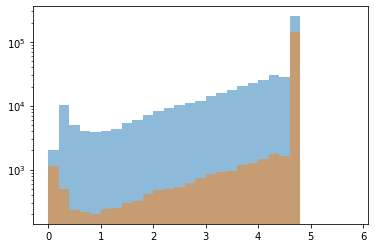

In [40]:
plt.hist(-np.log10(gnomad_afs[is_snp]), alpha=0.5, bins=np.arange(0, 6, 0.2), log=True)
plt.hist(-np.log10(gnomad_afs[~is_snp]), alpha=0.5, bins=np.arange(0, 6, 0.2), log=True)
plt.show()

In [36]:
class Family():
	def __init__(self, famkey):
		self.id = famkey
		self.parents_to_children = defaultdict(list)
		self.mat_ancestors = []
		self.pat_ancestors = []
		self.descendents = []
		self.ordered_couples = []
		self.individuals = []

	def add_child(self, child_id, mother_id, father_id):
		if child_id in self.mat_ancestors:
			self.mat_ancestors.remove(child_id)
		if child_id in self.pat_ancestors:
			self.pat_ancestors.remove(child_id)

		if mother_id not in self.individuals:
			self.mat_ancestors.append(mother_id)
		if father_id not in self.individuals:
			self.pat_ancestors.append(father_id)
		self.parents_to_children[(mother_id, father_id)].append(child_id)
		random.shuffle(self.parents_to_children[(mother_id, father_id)])

		self._reset_individuals()

	def get_parents(self, child_id):
		for ((mom, dad), children) in self.parents_to_children:
			if child_id in children:
				return (mom, dad)
		return None

	def _reset_individuals(self):
		self.descendents = []
		self.ordered_couples = []
		parents = set(self.parents_to_children.keys())
		while len(parents) > 0:
			already_added = set()
			for mom, dad in parents:
				if (mom in self.mat_ancestors or mom in self.descendents) and (dad in self.pat_ancestors or dad in self.descendents):
					self.ordered_couples.append((mom, dad))
					self.descendents.extend(self.parents_to_children[(mom, dad)])
					already_added.add((mom, dad))
			parents = parents - already_added
			if len(already_added) == 0:
				raise Exception('Circular pedigree.')
		self.individuals = self.mat_ancestors + self.pat_ancestors + self.descendents

	def __lt__(self, other):
		return self.id < other.id

	def __eq__(self, other):
		return self.id == other.id

	def __hash__(self):
		return hash(self.id)

	def __len__(self):
		return len(self.individuals)

	def __str__(self):
		return self.id

	def num_ancestors(self):
		return len(self.mat_ancestors) + len(self.pat_ancestors)

	def num_descendents(self):
		return len(self.descendents)


def pull_families(ped_file):
	# pull families from ped file
	families = dict()
	with open(ped_file, 'r') as f:	
		for line in f:
			pieces = line.strip().split('\t')
			if len(pieces) < 4:
				print('ped parsing error', line)
			else:
				fam_id, child_id, f_id, m_id = pieces[0:4]

				if f_id != '0' and m_id != '0':
					if fam_id not in families:
						families[fam_id] = Family(fam_id)
					families[fam_id].add_child(child_id, m_id, f_id)
	families = sorted([x for x in families.values()])
		
	print('families pulled %d' % len(families))
	return families

families = pull_families(ped_file)
ancestors = sorted(sum([x.mat_ancestors + x.pat_ancestors for x in families], []))
print('ancestors', len(ancestors))

families pulled 2454
ancestors 4919


In [37]:
# pull samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])
ind_indices = [sample_id_to_index[x] for x in ancestors if x in sample_id_to_index]  

# pull genotypes
data = sparse.load_npz('%s/chr.%s.%d.gen.npz' % (data_dir, chrom, batch_num))[ind_indices, :]
num_het = (data==1).sum(axis=0).A.flatten()
num_homalt = (data==2).sum(axis=0).A.flatten()
num_missing = (data<0).sum(axis=0).A.flatten()
num_homref = len(ind_indices) - num_het - num_homalt - num_missing
assert np.all(num_homref >= 0)

af = np.zeros((data.shape[1],))
all_missing = (num_homref + num_het + num_homalt) == 0
af[~all_missing] = (num_het[~all_missing] + 2*num_homalt[~all_missing])/(2*num_homref[~all_missing] + 2*num_het[~all_missing] + 2*num_homalt[~all_missing])


In [38]:
print(np.sum(all_missing), np.sum(~all_missing))

26 686112


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


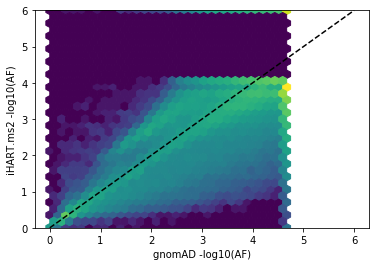

In [39]:
plt.hexbin(-np.log10(gnomad_afs[is_snp]), 
            np.clip(-np.log10(af[is_snp]), 0, 6), bins='log', gridsize=30)#, alpha=0.01, marker='.')
#plt.scatter(np.clip(-np.log10(gnomad_afs[~is_snp]), 0, 5), 
#            np.clip(-np.log10(af[~is_snp]), 0, 5), alpha=0.1, marker='.')
plt.plot([0, 6], [0, 6], color='black', linestyle='--')
plt.xlabel('gnomAD -log10(AF)')
plt.ylabel('iHART.ms2 -log10(AF)')

plt.show()